# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Алескин Александр Сергеевич

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [3]:
train = pd.read_csv('unimel_train.csv')

X_train = train.drop('Grant.Status', 1)
y_train = train['Grant.Status']
train = None

test = pd.read_csv('unimel_test.csv')

X_test = test.drop('Grant.Status', 1)
y_test = test['Grant.Status']
test = None

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

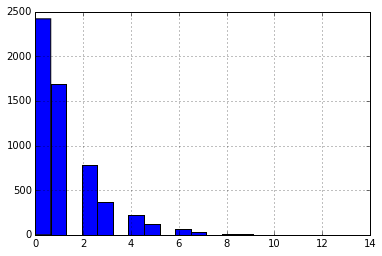

In [3]:
X_train['Number.of.Successful.Grant.1'].hist(bins=20)

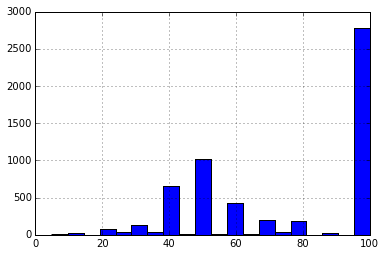

In [4]:
X_train['RFCD.Percentage.1'].hist(bins=20)

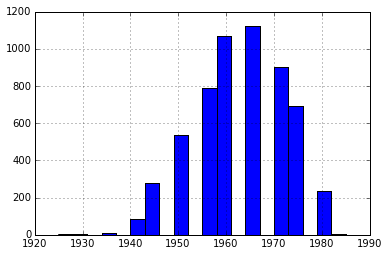

In [5]:
X_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

Значения распределены в разных числовых шкалах. При таких значениях градиентый спуск плохо сходиться. Масштабирование решает эту проблему.

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [6]:
print('всего пропущенных элементов: ', np.sum(np.sum(pd.isnull(X_train))))
print('Элементов, имеющих хотя бы один пропуск: ', np.sum(np.sum(pd.isnull(X_train), axis = 1) > 0))
print('Признаков, имеющих хотя бы одно пропущенное значение: ', np.sum(np.sum(pd.isnull(X_train), axis = 0) > 0))

всего пропущенных элементов:  26843
Элементов, имеющих хотя бы один пропуск:  5879
Признаков, имеющих хотя бы одно пропущенное значение:  38


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [4]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [5]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print( simple_data_dict)

dict_values([{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}])


In [6]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
print(transformer.fit_transform(simple_data_dict))

[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 1.  0.  0.  0.  1.]]


/home/alex/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [7]:
def transform_data(data, scaler, transformer, is_test, scaling = True):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    
    if is_test:
        scale = scaler.transform
        trans = transformer.transform
    else:
        scale = scaler.fit_transform
        trans = transformer.fit_transform
            
    scale_data = data[numeric_cols].fillna(0)
    if scaling:
        scale_data = scale(scale_data)
    
    categ_cols = [col for col in data.columns if col not in numeric_cols]
    categ_data = data[categ_cols].fillna('nan').astype(str)
    categ_data = trans(categ_data.T.to_dict().values()) # почему то sparce получается
    
    return (np.hstack((scale_data, categ_data)),  scaler, transformer)

Применяем функцию к данным:

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(X_train, scaler, transformer, False)
X_test, _, _ = transform_data(X_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [13]:
print( X.shape[1])

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [18]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lg = LogReg()

clf = GridSearchCV(lg, param_grid= {'C' : C_grid}, scoring = 'roc_auc', cv = cv, n_jobs = 1) # чудеса: n_jobs = 3 -- ошибка, n_jobs = 1 -- работает на всех свободных: 2.5
clf.fit(X, y_train)
best = clf.best_estimator_

predict = best.predict_proba(X_test)

print('наилучшее значение параметра С =  ', best.get_params()['C'])
print('AUC-ROC на тестовой выборке: ', roc_auc_score(y_test, predict[:, 1]))

наилучшее значение параметра С =   0.1
AUC-ROC на тестовой выборке:  0.880340804287


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [19]:
ans = np.zeros(len(C_grid), dtype = int)
print('параметр С |  число ненулевых коэффициентов')

for i in range(len(C_grid)):
    lg = LogReg(penalty = 'l1', C = C_grid[i])
    lg.fit(X, y_train)
    ans[i] = lg.coef_.size - np.sum(np.isclose(lg.coef_, 0))
    print(C_grid[i], '     |   ', ans[i])


параметр С |  число ненулевых коэффициентов
0.001      |    0
0.01      |    9
0.1      |    58
1.0      |    668
10.0      |    2424
100.0      |    2979


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [20]:
lg = LogReg(penalty = 'l1', C = 0.01)
lg.fit(X, y_train)
predict = lg.predict_proba(X_test)
print('AUC-ROC на тестовой выборке ', roc_auc_score(y_test, predict[:, 1]))

AUC-ROC на тестовой выборке  0.85254615488


Исходя из таблицы, для достижения такого качества нужно всего 9 признаков.

#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [21]:
lg = LogReg(C = 0.1)
lg.fit(X, y_train)
predict = lg.predict_proba(X_test)

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [22]:
from sklearn.metrics import average_precision_score, log_loss #, roc_all_score
print('AUC-ROC:  ', roc_auc_score(y_test, predict[:, 1]))
print('AUC-PR:   ', average_precision_score(y_test, predict[:, 1]))
print('log-loss: ', log_loss(y_test, predict[:, 1]))

AUC-ROC:   0.880340804287
AUC-PR:    0.838749398732
log-loss:  0.442742038351


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

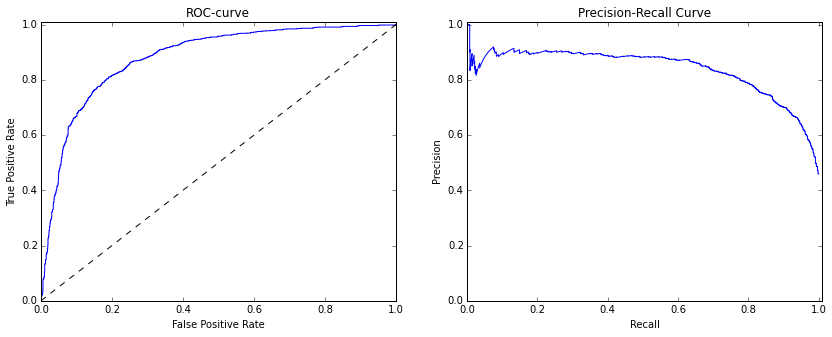

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, predict[:, 1])
precision, recall, thresholds = precision_recall_curve(y_test, predict[:, 1])

plt.figure(figsize = (14,5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')


plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [24]:
# вроде как монотонна

print('Наибольшая возможная точность при данном ограничении равна ', precision[np.argmin(recall > 0.9) - 1])
print('Порог для данных значений равен ', thresholds[np.argmin(recall > 0.9) - 1])

Наибольшая возможная точность при данном ограничении равна  0.701948051948
Порог для данных значений равен  0.314906886237


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [25]:
ind = np.argmin(recall > 0.9) - 1

F = 2 * recall[ind] * precision[ind] / (recall[ind] + precision[ind])
print('F-мера для точки, где полнота более 90%, а точность наибольшая, равна ', F)

F-мера для точки, где полнота более 90%, а точность наибольшая, равна  0.7887632251


Невысокое значение получается из формулы среднегармонического, то есть важно значение и точности.

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [26]:
over = np.where(precision > 0.8)[0]
index = over[np.argmax(recall[over])]

print('Наибольшая возможная полнота при данном ограничении равна ', recall[index])
print('Порог для данных значений равен ', thresholds[index])

Наибольшая возможная полнота при данном ограничении равна  0.776019983347
Порог для данных значений равен  0.530073801108


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [27]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

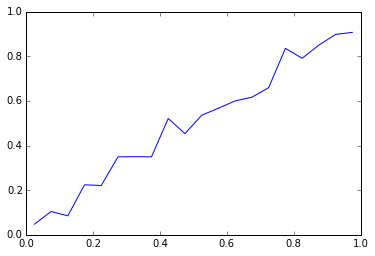

In [28]:
clf = LogReg(C=1.0)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

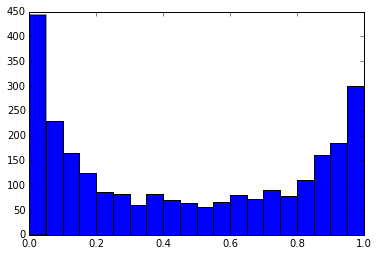

In [29]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [30]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

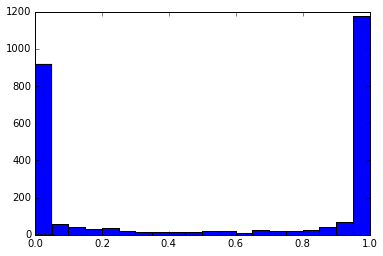

In [31]:
plt.hist(preds, bins=20)
plt.show()

Как видно, значения группируются в области 0 и 1. Вероятная причина это более слабые чем в логистической регресии штрафы за сильные ошибки.

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

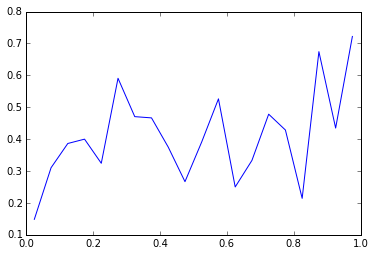

In [32]:
plot_calibration_curve(y_test, preds)

Кривая "недиагонального" вида.

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

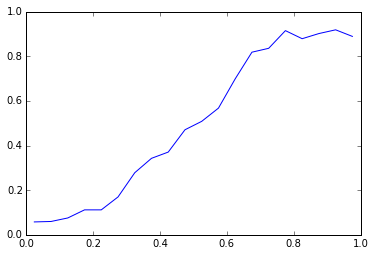

In [33]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'))
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Как видно, кривая стала значительно похоже на диагональную прямую

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

![](https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcRvH1JUNgPWjwFj2DzFpK486wsml9IxROdkgP4iqJGfsBcex0zPiQ)

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [11]:

X = np.hstack((X, np.ones((X.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [12]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return 1.0 / (1 + np.exp(- X.dot(w)))

In [13]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    return np.sum(np.log(1 + np.exp(-y * (X.dot(w)))), axis = 0) / y.size

In [14]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    Z = y.values[np.newaxis].T * X
    return - np.sum(Z / (1 + np.exp(Z.dot(w)))[np.newaxis].T, axis = 0) / y.size 

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [15]:
def grad_descent(X, y, step_size, max_iter, atol = 1e-8):
    
    w = np.zeros((X.shape[1]))
    last_val = get_func(w, X, y)
    iter_f = [last_val]
    it = 0
    execute = it < max_iter
    while(execute):
        dw = get_grad(w, X, y)
        w = w - step_size * dw
        val = get_func(w, X, y)
        iter_f.append(val)
        it += 1
        execute = (it < max_iter) and np.abs(last_val - val) > atol
        last_val = val
    return iter_f, w

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

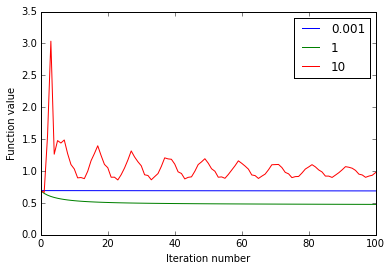

AUC-ROC равен  0.835083134215  при шаге равном  1


In [18]:
max_iter =  100
step = [0.001, 1, 10]
funcs_vals = []
step_res = np.zeros((3)) 

for i in range(len(step)):
    f, _ = grad_descent(X, y_train, step[i], max_iter)
    funcs_vals.append(f)
    step_res[i] = f[-1]
    plt.plot(f, label = str(step[i]))
    
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Function value')
plt.ylim([0.0, 3.5])
plt.show()

i = np.argmin(step_res)
_, w = grad_descent(X, y_train, step[i], max_iter)
predict = make_pred(X_test, w)
print('AUC-ROC равен ', roc_auc_score(y_test, predict), ' при шаге равном ', step[i])

Видно, что от параметра сильно зависит сходимость: при малом значении скорость сходимости очень маленькая, при слишком большом сходимости вообще нет. При С = 1 функционал уменьшается, но затем появляется аналогичная проблема как и при С = 10 -- метод не может схойтись так как "пролетает" более оптимальное значение из-за большого шага.

Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [19]:
def sgd(X, y, step_size, max_iter, atol = 1e-8):
    w = np.zeros((X.shape[1]))
    last_val = w
    iter_f = [get_func(w, X, y)]
    it = 0
    execute = it < max_iter
    ind = np.random.randint(0, X.shape[0] - 1, max_iter)
    while(execute):
        dw = get_grad(w, X[ind[it]], y[ind[it]:ind[it] + 1])
        w = w - step_size * dw
        val = w
        iter_f.append(get_func(w, X, y))
        it += 1
        execute = (it < max_iter) and np.linalg.norm(last_val - val) > atol
        last_val = val
    return iter_f, w

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

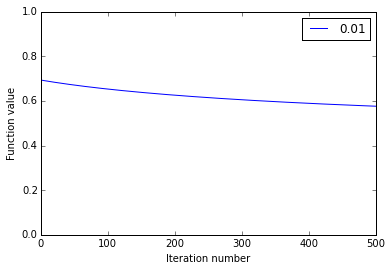

AUC-ROC равен  0.810342184157  при шаге равном  0.01


In [20]:
max_iter = 500
step = [0.0001, 0.001, 0.01, 0.1, 1, 5]

step_res = np.zeros((6)) 

for i in range(len(step)):
    f, _ = sgd(X, y_train, step[i], max_iter)
    funcs_vals.append(f)
    step_res[i] = f[-1]

i = np.argmin(step_res)
f, w = grad_descent(X, y_train, step[i], max_iter)
predict = make_pred(X_test, w)

plt.plot(f, label = str(step[i]))
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Function value')
plt.ylim([0.0, 1])
plt.show()

print('AUC-ROC равен ', roc_auc_score(y_test, predict), ' при шаге равном ', step[i])
    

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [56]:
train = pd.read_csv('unimel_train.csv')

X_train = train.drop('Grant.Status', 1)
y_train = train['Grant.Status']
train = None

test = pd.read_csv('unimel_test.csv')

X_test = test.drop('Grant.Status', 1)
y_test = test['Grant.Status']
test = None

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(X_train, scaler, transformer, False, False)
X_test, _, _ = transform_data(X_test, scaler, transformer, True, False)


X = np.hstack((X, np.ones((X.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

_, w = grad_descent(X, y_train, 0.1, max_iter = 500)
predict = make_pred(X_test, w)
print('AUC-ROC равен ', roc_auc_score(y_test, predict))

AUC-ROC равен  0.501396381203


Результат __значительно__ ухудшился, даже несмотря на увеличение итераций, и сравним с классификацией константой, если не хуже.

Здесь вы можете поделиться своими мыслями по поводу этой части.

Эх, слетать бы в Австралию...

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [4]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [7]:
from sklearn.linear_model import Ridge
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ans = []
for alpha in alpha_grid:
    rd = Ridge(alpha)
    rd.fit(X, y)
    predict = rd.predict(X_test)
    ans.append(np.linalg.norm(predict - y_test)**2 / y_test.size)
print('Наилучшее качество достигается при alpha =', alpha_grid[np.argmin(ans)])

Наилучшее качество достигается при alpha = 0.1


Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [9]:
from sklearn.metrics import r2_score
alpha = alpha_grid[np.argmin(ans)]
rd = Ridge(alpha)
rd.fit(X, y)
predict = rd.predict(X_test)
print('RMSE: ', np.linalg.norm(predict - y_test) / np.sqrt(y_test.size))
print('Коэффициент детерминации:', r2_score(y_test, predict))

RMSE:  55.6419819113
Коэффициент детерминации: 0.417024184822


Так как при точной классификации коэффициент равен 1.0, а при подстановки константы - 0, то данное значение говорит скорее о плохой модели.